
## Jupyter Notebook destiné à déterminer la part thermosensible dans la conso électrique  
#### Données issues de RTE sur l'hiver 2019/2020 exploitées afin de fiter la part du themosensible sur une année complète afin de l'extraire
Source: https://bilan-electrique-2020.rte-france.com/consommation-sensibilite-a-la-temperature-et-aux-usages/  
Source: https://realpython.com/linear-regression-in-python/
 

In [2]:
# Import des modules nécessaires
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
# Modules esthétiques
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 5]

### I.  import des données pour entrainement du modele

In [3]:
""""
Attention, pour éviter le bruit de mise à l'équilibre sur les 24 première heures (le temps que la moyenne glissante 
se construise), il faut importer les températures des 24 heures précédentes pour avoir la bonne moyenne qui prend en compte 
la vraie inertie dès le début !!
--> amélioration à intégrer dans les deux calculs de la température ci-dessous.
"""

print('Amélioration intégrée!')

Amélioration intégrée!


cal = pd.read_excel("California_2021_hourly_demand_MWh.xlsx")
cal.to_csv('dataframe_cal.txt', sep='\t', index=False)

In [6]:
# import des données des données d'entrainement du modèle (RTE sur période de octobre 2019 à mars 2020)
temp_moy_19_20 = np.loadtxt('temp_moy_CAL_2021.txt', dtype=float)
# p=np.loadtxt('part_thermo_RTE_19_20.txt', dtype=float)
p=np.loadtxt('dataframe_cal.txt', dtype=float)

In [7]:
## Mise en place d'une moyenne glissante sur la journée non pondérée pour les données d'entrainement
t= np.zeros(4368)
for i in range(24,4368+24):
    t[i-24]=temp_moy_19_20[i-24:i].mean()

### II.  import des données sur lesquelles on fit le modèle (température sur année complète + conso élec)

In [11]:
# Import des données sur lesquelles appliquer le modèle (attention, premier indice = 00h00)
conso_elec_2019 = np.loadtxt('conso_elec_2019.txt', dtype=float)/1000
# temp_moy_2019_brute = np.loadtxt('temp_moy_FR2019.txt', dtype=float)
temp_moy_2021_brute = np.loadtxt('temp_moy_CAL_2021.txt', dtype=float)

In [12]:
## Mise en place d'une moyenne glissante sur la journée non pondérée pour les données de fit du modèle
t_2019= np.zeros(8760)

for i in range(24,8760+24):
    t_2019[i-24]=temp_moy_2021_brute[i-24:i].mean()

    # Pour visualiser la moyenne glissante
# plt.plot(np.arange(8760),temp_moy_2019_brute[24:8784])
# plt.plot(np.arange(8760),t_2019)

### III. Mise en place du modèle sur un année complète commence à 00h00

In [13]:
# Mise en place d'une fonction calculant la puissance thermosensible à partir des deux modèles (24h et 168h)
# Partie entrainement sur données RTE hiver 2019-2020 avec une fonction qui renvoie reg linéaire par tranche horaire
def reg_lin_horaire(h,d):
    if d==24:
        indice=[h+24*i for i in range(182)] #pour un rafinage position heure dans une journée (=24h)
    if d==168:
        indice=[h+168*i for i in range(26)] #pour un rafinage position heure dans une semaine (=168h)
    p_d=np.take(p, indice)
    t_d=np.take(t, indice)
    t_d = t_d.reshape((-1, 1))
    
    model_lin = LinearRegression()
    model_lin.fit(t_d, p_d)
    
# Partie ou on fit sur les données année 2019 complète    
    # calcul prédiction sur données année complète
    i_annee=[h+24*i for i in range(365)]
    t_annee_d = np.take(t_2019,i_annee)
    t_annee_d = t_annee_d.reshape((-1, 1))
    result_2019 = model_lin.predict(t_annee_d)
    return result_2019

In [14]:
# boucle permettant de rassembler dans ordre chronologique (heure après heure) les résultats avec condition de non négativité
prediction_2019 = np.zeros(8760)
for i in range (365):
    for h in range (24):
        if reg_lin_horaire(h,24)[i]>= 0 :
            prediction_2019[24*i+h]= reg_lin_horaire(h,24)[i]
        else :
            prediction_2019[24*i+h]= 0

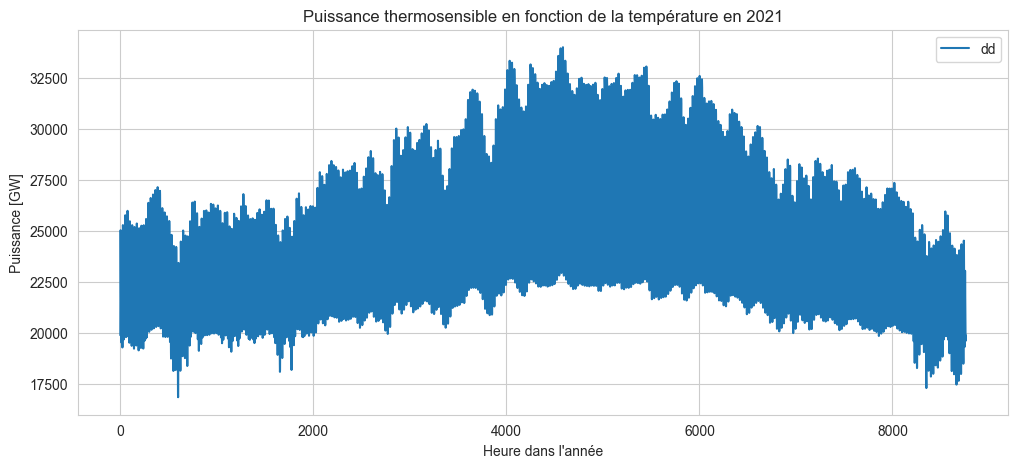

In [15]:
# Affichage du résultat
d=0
f=8760
plt.title('Puissance thermosensible en fonction de la température en 2021')
plt.plot(np.arange(f-d),prediction_2019[d:f],label='dd')
plt.xlabel("Heure dans l'année")
plt.ylabel("Puissance [GW]")
plt.legend()
plt.show()

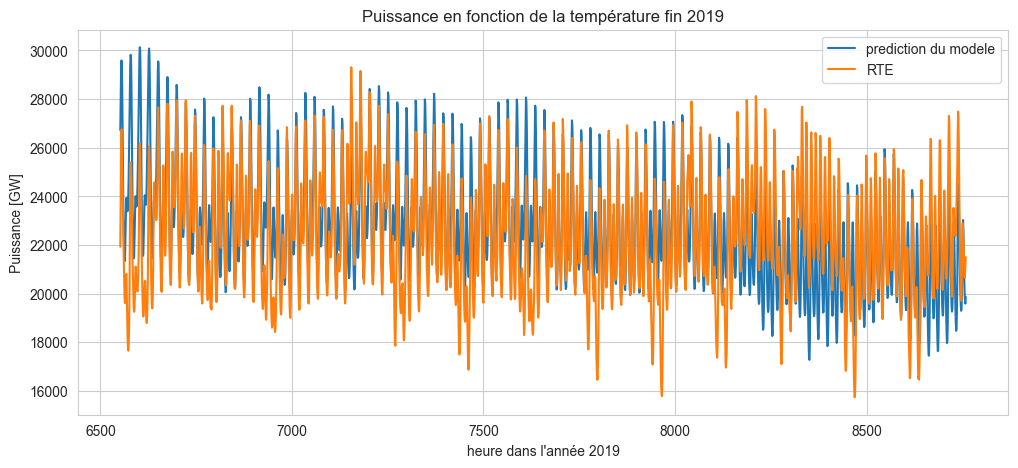

In [16]:
# Comparaison données sorties vs dataset d'entrainement (RTE) sur la fin de l'année 2019
plt.title('Puissance en fonction de la température fin 2019')
plt.plot(np.arange(6552,8760),prediction_2019[6552:8760],label='prediction du modele')
plt.plot(np.arange(6552,8760),p[0:8760-6552],label='RTE')
plt.xlabel("heure dans l'année 2019")
plt.ylabel("Puissance [GW]")
plt.legend()
plt.show()

In [17]:
# Evaluation de la performance sur la période de diponibilité des données d'entrainement RTE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
r2_score(prediction_2019[6552:8760],p[0:8760-6552]),mean_squared_error(prediction_2019[6552:8760],p[0:8760-6552]),

(0.3700441083352407, 3422936.4443048513)

In [18]:
val1=np.trapz(p[0:8760-6552], dx=1)/1000
val2=np.trapz(prediction_2019[6552:8760], dx=1)/1000
print(f"Consommation hiver 2019 pour chaleur res-tertiaire (en Twh) pour RTE: {val1} et pour modèle: {val2} ")

Consommation hiver 2019 pour chaleur res-tertiaire (en Twh) pour RTE: 49309.196 et pour modèle: 50010.14976275438 


: 

### IV. Calculs dérivés : conso spécifique et besoin de chaleur total par homothétie de la conso thermo élec

In [13]:
#Quel rapport d'homothétie sachant que la conso chaleur totale est de 466 Twh pour résidentiel/tertiaire pour chauffage
val=np.trapz(prediction_2019, dx=1)/1000 #pour passer de Gwh en Twh
print(f"Consommation 2019 pour chaleur res-tertiaire (en Twh) {val}")
r_homo=448/val

Consommation 2019 pour chaleur res-tertiaire (en Twh) 69.05355335493846


In [14]:
#Calcul de la part électrique spécifique pour toute l'année
conso_spe_2019=conso_elec_2019-prediction_2019
#Calcul homothétie pour avoir besoin de chaleur total
besoin_chaleur_2019=prediction_2019*r_homo

In [15]:
#export des donneés au format txt
np.savetxt('conso_elec_spe_2019.txt', conso_spe_2019)
np.savetxt('besoin_chaleur_homo_2019.txt', besoin_chaleur_2019)

In [16]:
#export des données au format xlsx

conso_spe_df = pd.DataFrame (conso_spe_2019) #convert your array into a dataframe
besoin_chaleur_df = pd.DataFrame (besoin_chaleur_2019) #convert your array into a dataframe


conso_spe_df.to_excel('conso_elec_spe_2019.xlsx', index=False)
besoin_chaleur_df.to_excel('besoin_chaleur_homo_2019.xlsx', index=False)

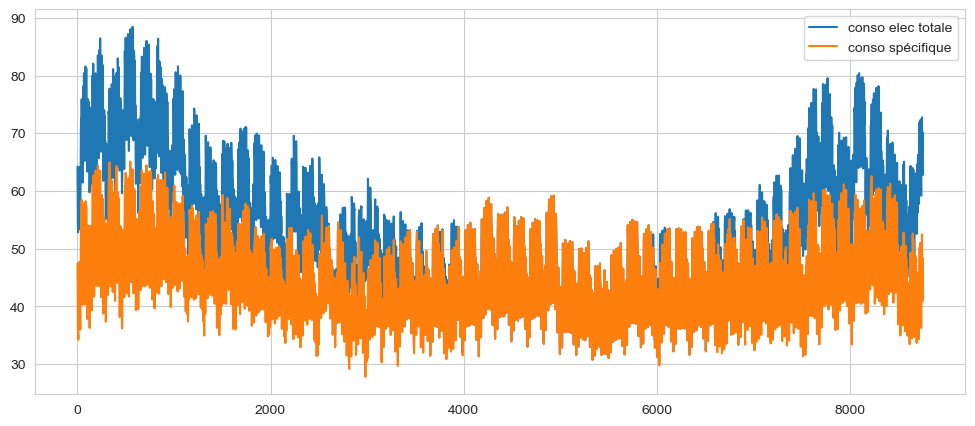

In [17]:
plt.plot(np.arange(8760),conso_elec_2019,label='conso elec totale')
plt.plot(np.arange(8760),conso_spe_2019, label='conso spécifique')
plt.legend()
plt.show()

In [18]:
# #tester a la main de calculer la conso totale
# plt.plot(np.arange(8760),besoin_chaleur_2019)
# np.trapz(besoin_chaleur_2019,dx=1)/1000

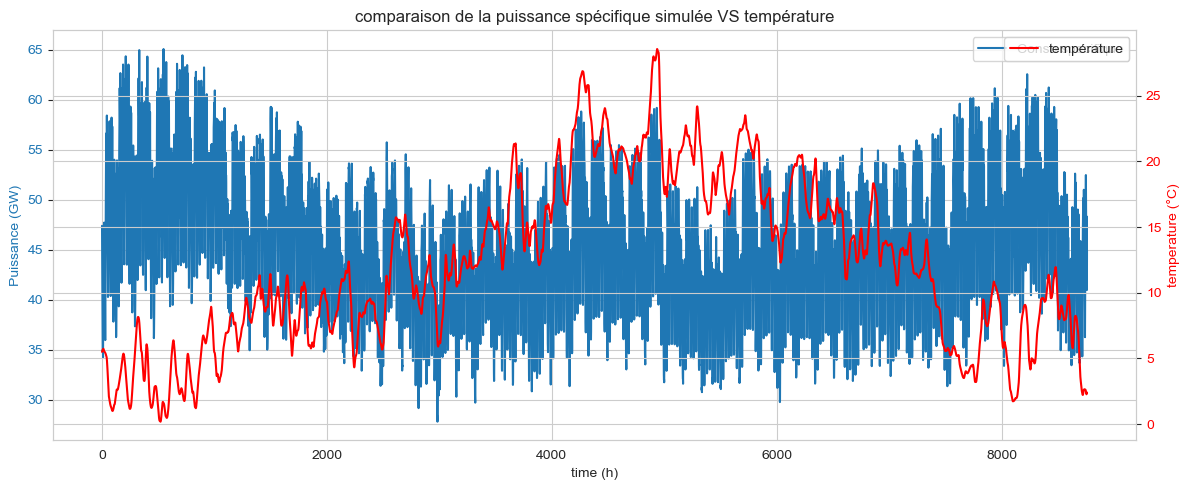

In [19]:
# Illustration de la conso spécifique et illustration du besoin en froid l'été (car pas pris en compte dans thermosensible ici)
d=0
f=8760
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time (h)')
ax1.set_ylabel('Puissance (GW)', color=color)
ax1.plot(np.arange(d,f,1), conso_spe_2019[d:f], color=color,
         label= 'Conso specifique')
ax1.tick_params(axis='y', labelcolor=color)
plt.legend()

# color = 'tab:orange'
# ax1.set_ylabel('Puissance (GW)', color=color)
# ax1.plot(np.arange(d,f,1), part_thermo_cor[d:f], color=color
#          , label= 'conso thermosensible SIMULEE')
# ax1.tick_params(axis='y', labelcolor=color)
# plt.legend()

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:red'
ax3.set_ylabel('temperature (°C)', color='r')  # we already handled the x-label with ax1
ax3.plot(np.arange(d,f,1), t_2019[d:f], color='r', label='température')
ax3.tick_params(axis='y', labelcolor='r')

plt.title('comparaison de la puissance spécifique simulée VS température')
plt.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()